# Convolutional Neural Network Notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/Flictionary'

In [3]:
from glob import glob
import ast
import cv2
import time
import ast
from tqdm import tqdm
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import datetime
import tempfile

from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNet

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential, load_model, save_model, Model, model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import CategoricalCrossentropy, CategoricalAccuracy, TopKCategoricalAccuracy


BASE_SIZE = 256
INPUT_DIR = os.path.join(base_dir, "animals/")
# DP_DIR = "../animals/shuffle_csv/"
# INPUT_DIR = '../animals/'
NCSVS = 100
NCATS = 47

In [4]:
! pip install sh

     |████████████████████████████████| 40 kB 3.2 MB/s 


In [4]:
startTime = time.time()

In [5]:
#clean spaces in name
classes_path = os.listdir(INPUT_DIR + 'train_simplified/')
classes_path = sorted(classes_path, key=lambda s: s.lower())
class_dict = {x[:-4]:i for i, x in enumerate(classes_path)}
labels = {x[:-4] for i, x in enumerate(classes_path)}

n_labels = len(labels)
print("Number of labels: {}".format(n_labels))

# fileList = glob(INPUT_DIR + "train_simplified/*.csv")     

n_files = n_labels 
size = 96


Number of labels: 47


In [6]:
class_dict

{'ant': 0,
 'bat': 1,
 'bear': 2,
 'bee': 3,
 'butterfly': 4,
 'camel': 5,
 'cat': 6,
 'cow': 7,
 'crab': 8,
 'crocodile': 9,
 'dog': 10,
 'dolphin': 11,
 'dragon': 12,
 'duck': 13,
 'elephant': 14,
 'flamingo': 15,
 'frog': 16,
 'giraffe': 17,
 'hedgehog': 18,
 'horse': 19,
 'kangaroo': 20,
 'lion': 21,
 'lobster': 22,
 'monkey': 23,
 'mosquito': 24,
 'mouse': 25,
 'octopus': 26,
 'owl': 27,
 'panda': 28,
 'parrot': 29,
 'penguin': 30,
 'pig': 31,
 'rabbit': 32,
 'raccoon': 33,
 'rhinoceros': 34,
 'scorpion': 35,
 'sea turtle': 36,
 'shark': 37,
 'sheep': 38,
 'snail': 39,
 'snake': 40,
 'spider': 41,
 'squirrel': 42,
 'swan': 43,
 'tiger': 44,
 'whale': 45,
 'zebra': 46}

In [7]:
labels

{'ant',
 'bat',
 'bear',
 'bee',
 'butterfly',
 'camel',
 'cat',
 'cow',
 'crab',
 'crocodile',
 'dog',
 'dolphin',
 'dragon',
 'duck',
 'elephant',
 'flamingo',
 'frog',
 'giraffe',
 'hedgehog',
 'horse',
 'kangaroo',
 'lion',
 'lobster',
 'monkey',
 'mosquito',
 'mouse',
 'octopus',
 'owl',
 'panda',
 'parrot',
 'penguin',
 'pig',
 'rabbit',
 'raccoon',
 'rhinoceros',
 'scorpion',
 'sea turtle',
 'shark',
 'sheep',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'swan',
 'tiger',
 'whale',
 'zebra'}

In [8]:
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def draw_cv2(raw_strokes, size=256, lw=6):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for stroke in raw_strokes:
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 255, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img


def df_to_image_array(df, size=size, lw=6):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i] = draw_cv2(raw_strokes, size=size, lw=lw)
    x = x / 255.
    x = x.reshape((len(df), size, size, 1)).astype(np.float32)
    return x




In [10]:
# For loading the pickles
import pickle
X_tr = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/pickle/X_train.pickle', 'rb'))
y_tr = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/pickle/y_train.pickle', 'rb'))
X_val = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/pickle/X_valid.pickle', 'rb'))
y_val = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/pickle/y_valid.pickle', 'rb'))
X_tt = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/pickle/X_test.pickle', 'rb'))
y_tt = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/pickle/y_test.pickle', 'rb'))

In [11]:
BATCH_SIZE = 32
SIZE = 96
N_CLASSES = 47

In [12]:
# image augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip = True)

# rescale pixel values for remaining datasets
datagen = ImageDataGenerator(rescale = 1./255)

# create train dataset with augmentation
train_generator = train_datagen.flow(X_tr, y_tr, 
                                    batch_size=BATCH_SIZE,
                                    seed=42)

# do not include augmentation into validation set
val_generator = datagen.flow(X_val, y_val,
                             batch_size=BATCH_SIZE,
                             seed=42)

# set shuffle to False and batch size to 1 for test dataset
test_generator = datagen.flow(X_tt, y_tt,
                              batch_size=1,
                              seed=42,
                              shuffle=False)   

In [13]:
# Hotfix function
def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = {'model_str': model_str}
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

# Run the function
make_keras_picklable()

In [14]:
base_model = MobileNet(input_shape=(size, size, 1), include_top=False, weights=None, classes=n_labels)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(n_labels, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy]
              )

In [16]:
lr_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                 factor=0.5, 
                                 patience=5,
                                 min_delta=0.005, 
                                 mode='max', 
                                 cooldown=3, 
                                 verbose=1)
filepath = '/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn/model.{epoch:02d}-{val_loss:.2f}.hdf5'
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_categorical_crossentropy', 
                           mode = 'min')
log_dir = "/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')
csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn/log.csv')


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 48, 48, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 48, 48, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 48, 48, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 48, 48, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 48, 48, 32)        0     

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn/model.{epoch:02d}-{val_loss:.2f}.hdf5')

In [18]:
histories = []
history = model.fit_generator(generator = train_generator,
                               validation_data = val_generator,
                               steps_per_epoch = len(train_generator),
                               validation_steps = len(val_generator),
                               epochs = 30,
                               verbose = 1,
                               callbacks = [lr_reduction, mcp_save, csv_logger])
histories.append(history)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
2500/2500 [==============================] - 130s 43ms/step - loss: 3.6653 - categorical_crossentropy: 3.6653 - categorical_accuracy: 0.0526 - top_3_accuracy: 0.1473 - val_loss: 3.6286 - val_categorical_crossentropy: 3.6286 - val_categorical_accuracy: 0.0753 - val_top_3_accuracy: 0.1954

Epoch 00001: saving model to /content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn/model.01-3.63.hdf5
Epoch 2/30
2500/2500 [==============================] - 100s 40ms/step - loss: 3.4758 - categorical_crossentropy: 3.4758 - categorical_accuracy: 0.0837 - top_3_accuracy: 0.2154 - val_loss: 3.3094 - val_categorical_crossentropy: 3.3094 - val_categorical_accuracy: 0.1190 - val_top_3_accuracy: 0.2847

Epoch 00002: saving model to /content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn/model.02-3.31.hdf5
Epoch 3/30
2500/2500 [==============================] - 107s 43ms/step - loss: 3.3295 - categorical_crossentropy: 3.3295 - categorical_accuracy: 0.1169 - top_3_accuracy: 0.2765

In [ ]:
history = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_cnn_3/log.csv')

In [28]:
hist_df = pd.concat([pd.DataFrame(history.history) for history in histories], sort=True)
hist_df

,categorical_accuracy,categorical_crossentropy,loss,lr,top_3_accuracy,val_categorical_accuracy,val_categorical_crossentropy,val_loss,val_top_3_accuracy
0,0.052563,3.665307,3.665307,0.00010,0.147325,0.0753,3.628644,3.628644,0.1954
1,0.083675,3.475821,3.475821,0.00010,0.215412,0.1190,3.309351,3.309351,0.2847
2,0.116900,3.329475,3.329475,0.00010,0.276475,0.1775,3.095584,3.095584,0.3684
3,0.168238,3.101359,3.101359,0.00010,0.356113,0.2538,2.727202,2.727202,0.4789
4,0.222450,2.862970,2.862970,0.00010,0.434825,0.3319,2.364644,2.364644,0.5781
5,0.276450,2.657748,2.657748,0.00010,0.494087,0.3769,2.211344,2.211344,0.6143
6,0.317900,2.478634,2.478634,0.00010,0.545388,0.4192,2.047560,2.047560,0.6568
7,0.353337,2.336143,2.336143,0.00010,0.586000,0.4634,1.854272,1.854272,0.7084
8,0.383850,2.221773,2.221773,0.00010,0.614075,0.4920,1.781490,1.781490,0.7175
9,0.409038,2.115996,2.115996,0.00010,0.641050,0.5231,1.671077,1.671077,0.7539


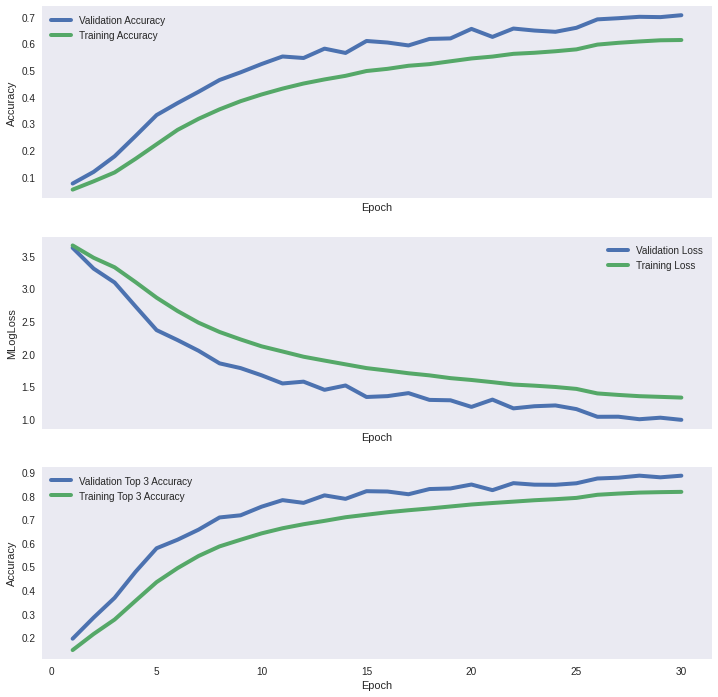

In [31]:

# Create visualizations for training vs. validation metrics
hist_df.index = np.arange(1, len(hist_df)+1)
plt.style.use('seaborn')
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(12, 12))
axs[0].plot(hist_df.val_categorical_accuracy, lw=4, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=4, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_loss, lw=4, label='Validation Loss')
axs[1].plot(hist_df.loss, lw=4, label='Training Loss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
axs[2].plot(hist_df.val_top_3_accuracy, lw=4, label='Validation Top 3 Accuracy')
axs[2].plot(hist_df.top_3_accuracy, lw=4, label='Training Top 3 Accuracy')
axs[2].set_ylabel('Accuracy')
axs[2].set_xlabel('Epoch')
axs[2].grid()
axs[2].legend(loc=0)
fig.savefig('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/history2.png', dpi=300)
plt.show();

In [32]:
plt.style.use('seaborn')
def generate_graph(history, title):
    plt.plot(history['categorical_accuracy'])
    plt.plot(history['val_categorical_accuracy'])
    plt.plot(history['top_3_accuracy'])
    plt.plot(history['val_top_3_accuracy'])
    plt.title('Accuracy ' + title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation', 'test top 3', 'validation top 3'], loc='upper left')
    plt.show()
    plt.plot(history['categorical_crossentropy'])
    plt.plot(history['val_categorical_crossentropy'])
    plt.title('Loss ' + title)
    plt.ylabel('MLogLoss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [34]:
#plot
generate_graph(histor, "Scores")

TypeError: ignored

In [ ]:
endTime = time.time()
print(endTime - startTime)

3108.745754003525
